.. meta::
   :description: A guide which introduces the most important steps to get started with pymoo, an open-source multi-objective optimization framework in Python.

.. meta::
   :keywords: Multi-objective Optimization, Python, Evolutionary Computation, Optimization Test Problem, Hypervolume

# Part II: Find a Solution Set using Multi-objective Optimization

\begin{align} 
\begin{split}
\min \;\; & f_1(x) = 100 \, (x_1^2 + x_2^2) \\ 
\max \;\; & f_2(x) = -(x_1-1)^2 - x_2^2 \\[1mm]
\text{s.t.} \;\; & g_1(x) = 2 \, (x_1 - 0.1) \, (x_1 - 0.9) \leq 0\\ 
& g_2(x) = 20 \, (x_1 - 0.4) \, (x_1 - 0.6) \geq 0\\[1mm] 
& -2 \leq x_1 \leq 2 \\
& -2 \leq x_2 \leq 2\\[1mm] 
& x \in \mathbb{R}
\end{split}
\end{align}

To implement the problem in **pymoo** some more work has to be done. 

Thus, we need to multiple an objective that is supposed to be maximized by $-1$ and minimize it. This results in minimizing $-f_2(x)$ instead of maximizing $f_2(x)$. 

Moreover, the inequality constraints need to be formulated as **less than zero**  ($\leq 0$) constraint. 
For this reason, $g_2(x)$ is multiplied by $-1$ in order to flip inequality relation. 
Also, we recommend the normalization of constraints to make them operating on the same scale and giving them equal importance. For $g_1(x)$, the coefficient results in $2 \cdot (-0.1) \cdot (-0.9) = 0.18$ and for $g_2(x)$ in $20 \cdot (-0.4) \cdot (-0.6) = 4.8$, respectively. We achieve normalization of constraints by dividing $g_1(x)$ and $g_2(x)$ by its corresponding coefficient.

After these reformulations the problem to be implemented is given by:

\begin{align} 
\label{eq:getting_started_pymoo}
\begin{split}
\min \;\; & f_1(x) = 100 \, (x_1^2 + x_2^2) \\ 
\min \;\; & f_2(x) = (x_1-1)^2 + x_2^2 \\[1mm] 
\text{s.t.} \;\; & g_1(x) = 2 \, (x_1 - 0.1) \, (x_1 - 0.9)  \, /  \,  0.18 \leq 0\\ 
& g_2(x) = - 20 \, (x_1 - 0.4) \, (x_1 - 0.6) \,  /  \,  4.8 \leq 0\\[1mm] 
& -2 \leq x_1 \leq 2 \\
& -2 \leq x_2 \leq 2\\[1mm] 
& x \in \mathbb{R}
\end{split}
\end{align}



## Implement the Problem

After having formulated the problem the right way, we can start implementing it. In this tutorial we the element-wise problem definition, which is one out of three different ways for implementing a problem. We define a new Python objective inheriting from `ElementwiseProblem` and set the correct attributes, such as the number of objectives (`n_obj`) and constraints (`n_constr`) and the lower (`xl`) and upper bounds (`xu`). The function being responsible for the evaluation is `_evaluate` which shall be implemented next. The function's interface is the parameters `x` and `out`. For this element-wise implementation `x` is a **one**-dimensional NumPy array of length `n_var` which represents a single solution to be evaluated. The output is supposed to be written to the dictionary `out`. The objective values should be written to `out["F"]` as a list of NumPy array with length of `n_obj` and the constraints to `out["G"]` with length of `n_constr` (if the problem has constraints to be satisfied at all).

In [1]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2, 
                         n_obj=2, 
                         n_ieq_constr=2, 
                         xl=np.array([-2,-2]), 
                         xu=np.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 100 * (x[0]**2 + x[1]**2)
        f2 = (x[0]-1)**2 + x[1]**2
        
        g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8
        
        out["F"] = [f1, f2]
        out["G"] = [g1, g2]
        

problem = MyProblem()

If you use **pymoo** as a researcher trying to improve existing algorithms, you might want to have a look at the varierity of single- and many-objective optimization test problems already implemented. 

[Optimization Test Problems](../problems/index.ipynb) | 
[Define a Custom Problem](../problems/definition.ipynb) | 
[Parallelization](../problems/parallelization.ipynb) |
[Callback](../interface/callback.ipynb) |
[Constraint Handling](../constraints/index.ipynb)

## Initialize an Algorithm

The reason why you became aware of this framework, is probably the existence of an algorithm you like to use. 
*pymoo* follows an object oriented approach and, thus, we have to define an algorithm object next. 
Depending on the optimization problem, different algorithms will perform better or worse on different kind of problems. It is recommendable to first understand the intuition behind an algorithm and then select one which seems to be most suitable for solving your optimization problem. A list of algorithms which are available in *pymoo* is available [here](../algorithms/index.ipynb).

In [2]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)



The `algorithm` object contains an implementation of NSGA-II with the custom configuration discussed above. The object can now be used to start an optimization run.

## Define a Termination Criterion

Furthermore, a termination criterion needs to be defined to start the optimization procedure. Most common ways of defining the termination is by limiting the overall number of function evaluations or simply the number of iterations of the algorithm.
Moreover, some algorithms already have implemented their own, for instance Nelder-Mead when the simplex becomes degenerated or CMA-ES where a vendor library is used. 
Because of the simplicity of this problem we use a rather small number of 40 iteration of the algorithm. 

In [3]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 40)

.. tip::
    A convergence analysis will show how much progress an algorithm has made at what time. Always keep in mind that having the most suitable algorithm but running it not long enough might prevent from finding the global optimum. However, continuing with optimization of an algorithm that got stuck or has already found the optimum will not improve the best found solution and unnecessarily increase the number of function evaluations.

You can find a list and explanations of termination criteria available in *pymoo* [here](../interface/termination.ipynb). If no termination criteria is defined, then the progress in the design and objective space will kept track of in each iteration. When no significant progress has been made (this is the art of defining what that shall be), the algorithm terminates. 

## Optimize

Finally, we are solving the `problem` with the `algorithm` and `termination` we have defined. The functional interface uses the `minimize` method. By default, the `minimize` performs deep-copies of the algorithm and the termination object which guarantees they are not modified during the function call. This is important to ensure that repetitive function calls with the same random seed end up with the same results. When the algorithm has been terminated, the `minimize` function returns a [Result](../interface/result.ipynb) object.

In [4]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      1 |  0.000000E+00 |  2.363992E+01 |             - |             -
     2 |       50 |      2 |  0.000000E+00 |  1.214993E+01 |  1.0000000000 |         ideal
     3 |       60 |      2 |  0.000000E+00 |  6.2891432227 |  0.000000E+00 |             f
     4 |       70 |      3 |  0.000000E+00 |  3.0711269306 |  0.9187378219 |         ideal
     5 |       80 |      3 |  0.000000E+00 |  1.6281231204 |  0.2625963068 |         ideal
     6 |       90 |      4 |  0.000000E+00 |  0.5267534927 |  0.0328919404 |             f
     7 |      100 |      5 |  0.000000E+00 |  0.0905448026 |  0.0431258458 |             f
     8 |      110 |      7 |  0.000000E+00 |  0.000000E+00 |  0.2017578962 |         ideal
     9 |      120 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0073755952 |             f
    10 |      130 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0077998310 |             f

If the `verbose=True`, some printouts during the algorithm's execution are provided. This can very from algorithm to algorithm. Here, we execute `NSGA2` on a problem where *pymoo* has no knowledge about the optimum. Each line represents one iteration. The first two columns are the current generation counter and the number of evaluations so far. For constrained problems, the next two columns show the minimum constraint violation (*cv (min)*) and the average constraint violation (*cv (avg)*) in the current population. This is followed by the number of non-dominated solutions (*n_nds*) and two more metrics which represents the movement in the objective space. 

## Visualize

Analyzing the solutions being found by the algorithm is vital. Always a good start is visualizing the solutions to get a grasp of commonalities or if the Pareto-front is known to even check the convergence.

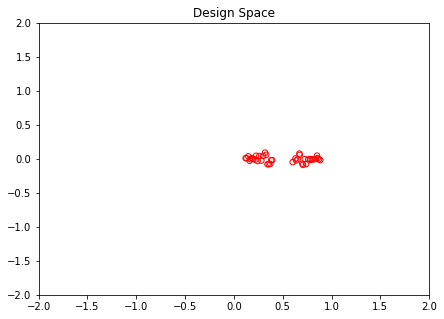

In [5]:
import matplotlib.pyplot as plt
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

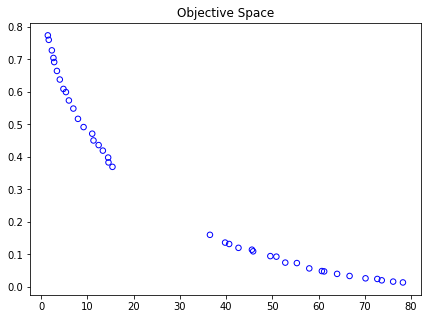

In [6]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()